In [1]:
# Checking Python's version
!python -V

Python 3.9.16


In [2]:
# Importing libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (roc_auc_score,
                             confusion_matrix,
                             classification_report)

In [3]:
# # Import data
# df = pd.read_csv('./data/marketing_campaign.csv', delimiter=';')

In [4]:
# # Check data information
# df.info()

In [5]:
# # Transform `Dt_Customer` to datetime dtype
# df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [6]:
# # Training and Validation Data

# # Check year range of the data
# df["Dt_Customer"].max().year
# df["Dt_Customer"].min().year

# # Use years before 2014 as training data
# training_data = (
#     df[df['Dt_Customer'].dt.year < 2014]
#     .reset_index()
#     .drop(['index'], axis=1)
# )

# # Use 2014 as the validation data
# validation_data = (
#     df[df['Dt_Customer'].dt.year >=2014].reset_index()
#     .drop(['index'], axis=1)
# )

# # Save training data to folder
# training_data.to_csv('./data/training_data.csv', index=False)

# # Save validation data to folder
# validation_data.to_csv('./data/validation_data.csv', index=False)

# # Check shape of training and validation data
# training_data.shape, validation_data.shape

In [7]:
df_train = pd.read_csv('./data/training_data.csv')
df_val = pd.read_csv('./data/validation_data.csv')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1683 non-null   int64  
 1   Year_Birth           1683 non-null   int64  
 2   Education            1683 non-null   object 
 3   Marital_Status       1683 non-null   object 
 4   Income               1663 non-null   float64
 5   Kidhome              1683 non-null   int64  
 6   Teenhome             1683 non-null   int64  
 7   Dt_Customer          1683 non-null   object 
 8   Recency              1683 non-null   int64  
 9   MntWines             1683 non-null   int64  
 10  MntFruits            1683 non-null   int64  
 11  MntMeatProducts      1683 non-null   int64  
 12  MntFishProducts      1683 non-null   int64  
 13  MntSweetProducts     1683 non-null   int64  
 14  MntGoldProds         1683 non-null   int64  
 15  NumDealsPurchases    1683 non-null   i

In [9]:
# Check feature diversity
df_train.nunique()

# Droping redundant features
red_ftrs_1 = ["ID", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Response"]

y_train = df_train['Response']
y_val = df_val['Response']

df_train_2 = df_train.copy()
df_train = df_train.drop(red_ftrs_1, axis=1)

In [10]:
# Creating list of categorical features
categ_ftrs_1 = list(
    df_train.nunique()
    [(df_train.nunique() <= 8)]
    .index
)
not_categ = ['TeenHome', 'KidHome']
categ_ftrs_1 = [categ for categ in categ_ftrs_1 
              if categ not in not_categ]

# Creating a list of numerical features
num_ftrs_1 = [col for col in df_train.columns 
            if col not in categ_ftrs_1]


In [11]:
# Handling missing values
df_train.isna().sum()

df_train[num_ftrs_1] = (
    df_train[num_ftrs_1].fillna(df_train[num_ftrs_1].median())
)

df_train[categ_ftrs_1] = (
    df_train[categ_ftrs_1].fillna(df_train[categ_ftrs_1].mode().iloc[0])
)

In [12]:
# look at purchases as a whole
purchases = list(df_train.filter(regex='Purchases').columns)
df_train['total_purchases'] = (
    df_train['NumCatalogPurchases'] + df_train['NumDealsPurchases'] + 
    df_train['NumStorePurchases'] + df_train['NumWebPurchases']
)

# look at amounts as a whole
amount = list(df_train.filter(regex='Mnt').columns)
df_train['total_amount'] = (
    df_train['MntFishProducts'] + df_train['MntFruits'] + 
    df_train['MntGoldProds'] + df_train['MntMeatProducts'] + 
    df_train['MntSweetProducts'] + df_train['MntWines']
)

# add a dependants feature
dependants = list(df_train.filter(regex='home').columns)
df_train['dependants'] = df_train['Kidhome'] + df_train['Teenhome']

# Drop redundant features
red_ftrs_2 = dependants+amount+purchases
df_train = df_train.drop(red_ftrs_2, axis=1)

In [13]:
# Creating list of categorical features
categ_ftrs_2 = list(
    df_train.nunique()
    [(df_train.nunique() <= 8)]
    .index
)

categ_ftrs_2 = [categ for categ in categ_ftrs_2
              if categ not in ['dependants']]

# Encode categorical variables
df_train[categ_ftrs_2] = (
    df_train[categ_ftrs_2].astype('category')
    .apply(lambda x: x.cat.codes)
    ) 

# Creating a list of numerical features
num_ftrs_2 = [col for col in df_train.columns 
            if col not in categ_ftrs_2]


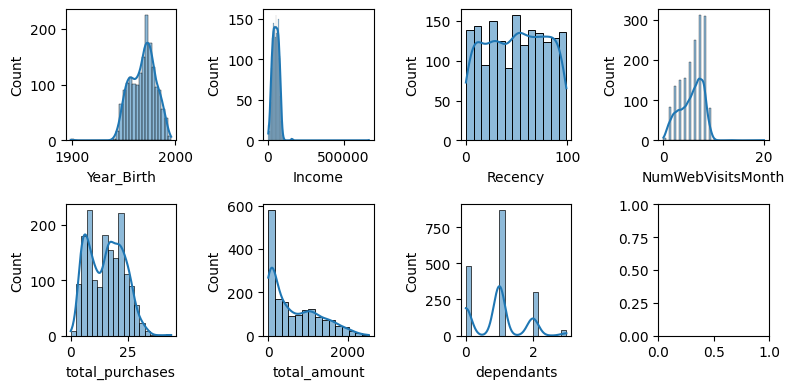

In [14]:
# Check distribution of numerical features
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
axes = axes.flatten()

for i, var in enumerate(num_ftrs_2):
        sns.histplot(x=var, ax=axes[i], data=df_train, kde=True, )
plt.tight_layout()

In [15]:
def clean_data(df):
    
    # Drop redundant features
    df = df.drop(red_ftrs_1, axis=1)
    
    # Handling missing values and transformations
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('normalize', MinMaxScaler()),
    ])
    
    ct = ColumnTransformer([
        ('num_trans', num_transformer, num_ftrs_1),
        ('cat_trans', SimpleImputer(strategy='most_frequent'), categ_ftrs_1)
    ])
    
    df = pd.DataFrame(ct.fit_transform(df), columns=num_ftrs_1+categ_ftrs_1)
    
    # Compute total purchase
    df['total_purchases'] = (
        df['NumCatalogPurchases'] + df['NumDealsPurchases'] + 
        df['NumStorePurchases'] + df['NumWebPurchases']
    )
    
    # Compute total amount
    df['total_amount'] = (
        df['MntFishProducts'] + df['MntFruits'] + 
        df['MntGoldProds'] + df['MntMeatProducts'] +
        df['MntSweetProducts'] + df['MntWines']
    )
    
    # Add a `dependants` feature
    df['dependants'] = df['Kidhome'] + df['Teenhome']
    
    
    # Drop superflous columns
    df = df.drop(red_ftrs_2, axis=1)

    # Encode categorical variables
    df[categ_ftrs_2] = (
        df[categ_ftrs_2].astype('category')
        .apply(lambda x: x.cat.codes)
    ) 
    
    return df

In [16]:
train_dicts= clean_data(df_train_2).to_dict(orient='records')
val_dicts = clean_data(df_val).to_dict(orient='records')

In [17]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [18]:
lr = LogisticRegression()
lr.fit(X_train, y_train.values)
y_pred = lr.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1397
           1       0.74      0.35      0.48       286

    accuracy                           0.87      1683
   macro avg       0.81      0.66      0.70      1683
weighted avg       0.86      0.87      0.85      1683



/home/mgubuntu/anaconda3/envs/marketing_MLOps/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

/home/mgubuntu/anaconda3/envs/marketing_MLOps/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
cmat = confusion_matrix(y_val, y_pred)
cols = pd.MultiIndex.from_tuples(
    [('predictions', 0), ('predictions', 1)]
)
indx = pd.MultiIndex.from_tuples(
    [('actual', 0), ('actual', 1)]
)
    
display(pd.DataFrame(cmat, columns=cols, index=indx))


predictions    
                   0   1
actual 0         489  20
       1          23  25

In [21]:

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       509
           1       0.56      0.52      0.54        48

    accuracy                           0.92       557
   macro avg       0.76      0.74      0.75       557
weighted avg       0.92      0.92      0.92       557



In [22]:
roc_auc_score(y_val, lr.decision_function(X_val))

0.8926612639161755

In [23]:
lr.predict_proba(X_val)

array([[0.95452829, 0.04547171],
       [0.90473715, 0.09526285],
       [0.94955118, 0.05044882],
       ...,
       [0.84552979, 0.15447021],
       [0.89033285, 0.10966715],
       [0.8247417 , 0.1752583 ]])